In [1]:
from functools import partial
import sys
import pandas as pd
import numpy as np
import talib as ta

sys.path.append('..')
pd.set_option("plotting.backend", "plotly")
sector_df = pd.read_hdf('../data/cleaned_data.h5').droplevel(0)
shanghai_composite = pd.read_hdf('../data/shanghai_composite.h5', key='shanghai_composite')
factors = pd.read_hdf('../data/ch3factors.h5', key='factors')

### GET SUMMARY STATISTICS FOR ALL THE INDICES

In [2]:
# create a table for 1. Data start date, 2. Annualized mean, 3. annualized volatility for each column for df
def get_annualized_mean(df):
    return df.mean() * 252

def get_annualized_volatility(df):
    return df.std() * np.sqrt(252)

def get_annualized_sharpe_ratio(df):
    return get_annualized_mean(df) / get_annualized_volatility(df)

In [3]:
annualized_mean_returns = sector_df.pct_change().apply(get_annualized_mean).to_frame('Annualized Mean')
annualized_volatility = sector_df.pct_change().apply(get_annualized_volatility).to_frame('Annualized Volatility')
annualized_sharpe_ratio = sector_df.pct_change().apply(get_annualized_sharpe_ratio).to_frame('Annualized Sharpe Ratio')
start_dates = sector_df.apply(lambda x: x.dropna().index[0]).to_frame('Start Date')

In [4]:
annualized_table = pd.concat([start_dates, annualized_mean_returns, annualized_volatility, annualized_sharpe_ratio], axis=1)

In [5]:
shanghai_composite.rename(columns={'close': '000001'}, inplace=True)

In [6]:
shanghai_composite_annualized_mean_returns = shanghai_composite.pct_change().apply(get_annualized_mean).to_frame('Annualized Mean')
shanghai_composite_annualized_volatility = shanghai_composite.pct_change().apply(get_annualized_volatility).to_frame('Annualized Volatility')
shanghai_composite_annualized_sharpe_ratio = shanghai_composite.pct_change().apply(get_annualized_sharpe_ratio).to_frame('Annualized Sharpe Ratio')
shanghai_composite_start_dates = shanghai_composite.apply(lambda x: x.dropna().index[0]).to_frame('Start Date')

In [7]:
shanghai_composite_annualized_table = pd.concat([shanghai_composite_start_dates, shanghai_composite_annualized_mean_returns, shanghai_composite_annualized_volatility, shanghai_composite_annualized_sharpe_ratio], axis=1)

In [8]:
summary_stats = pd.concat([annualized_table, shanghai_composite_annualized_table], axis=0)
summary_stats.index.name = "tickers"
from src import config
converter = config.ticker_to_en_name
summary_stats['Start Date'] = summary_stats['Start Date'].dt.to_period('M')
summary_stats.index = summary_stats.index.map(converter, na_action='ignore')
summary_stats = summary_stats.round(3)

### GET TOTAL ALPHAS AND BETAS FOR EACH SECTOR

In [9]:
factors.index = factors.index.to_period('M')
factors.drop(columns=['rf_mon'], inplace=True)

In [10]:
sector_df_monthly = sector_df.resample('M').last()
sector_df_monthly.index = sector_df_monthly.index.to_period('M')
sector_df_monthly = sector_df_monthly.pct_change().dropna()

In [11]:
# make the length of both df_monthly and factors the same, one is longer at one end, the other is longer at the other end
factors = factors.loc[sector_df_monthly.index[0]:factors.index[-1]]
sector_df_monthly = sector_df_monthly.loc[factors.index[0]:factors.index[-1]]

## SAME logic using statsmodels.api but with p_values calculated. 
However, the alpha values are somewhat different so i don't know. these are monthly alphas so all good. 

In [14]:
import statsmodels.api as sm

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=sector_df_monthly.columns, 
                          columns=['mktrf', 'SMB', 'VMG', 'alpha', 'p_alpha'])

for ticker in sector_df_monthly.columns:
    X = sm.add_constant(factors)
    model = sm.OLS(sector_df_monthly[ticker], X)
    results = model.fit()
    
    # Store the coefficients
    results_df.loc[ticker, ['mktrf', 'SMB', 'VMG']] = results.params[1:]
    results_df.loc[ticker, 'alpha'] = results.params[0]
    
    # Store the p-values
    # results_df.loc[ticker, ['p_mktrf', 'p_SMB', 'p_VMG']] = results.pvalues[1:]
    results_df.loc[ticker, 'p_alpha'] = results.pvalues[0]

# Function to add stars to p-values
def significance_stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

# Apply the function to the p-values
results_df['p_alpha'] = results_df['p_alpha'].apply(significance_stars)

In [15]:
results_df = results_df.reindex(columns=['alpha', 'p_alpha', 'mktrf', 'SMB', 'VMG'])
results_df.index = results_df.index.map(converter, na_action='ignore')
results_df = results_df.convert_dtypes(float).round(3)

## PLOT the rolling alphas

In [67]:
# Create a MultiIndex DataFrame to store the results
index = pd.MultiIndex.from_product([[],[]], names=['ticker', 'date'])
factor_exposures_rolling = pd.DataFrame(index=index, 
                                   columns=factors.columns.append(pd.Index(['alpha'])))

# Number of periods in a 6-month window
window = 12

# Loop over each 6-month window
for i in range(window, len(sector_df_monthly)):
    # Get the data for the current window
    window_factor_returns = factors.iloc[i-window:i]
    window_asset_returns = sector_df_monthly.iloc[i-window:i]

    for ticker in sector_df_monthly.columns:
        # Fit a linear regression model
        X = sm.add_constant(window_factor_returns)
        model = sm.OLS(window_asset_returns[ticker], X)
        results = model.fit()

        # Store the factor exposures and alpha
        factor_exposures_rolling.loc[(ticker, sector_df_monthly.index[i]), factors.columns] = results.params[1:]
        factor_exposures_rolling.loc[(ticker, sector_df_monthly.index[i]), 'alpha'] = results.params[0]

In [68]:
# convert the index to datetime
factor_exposures_rolling.index = factor_exposures_rolling.index.set_levels(factor_exposures_rolling.index.levels[1].to_timestamp(), level=1)

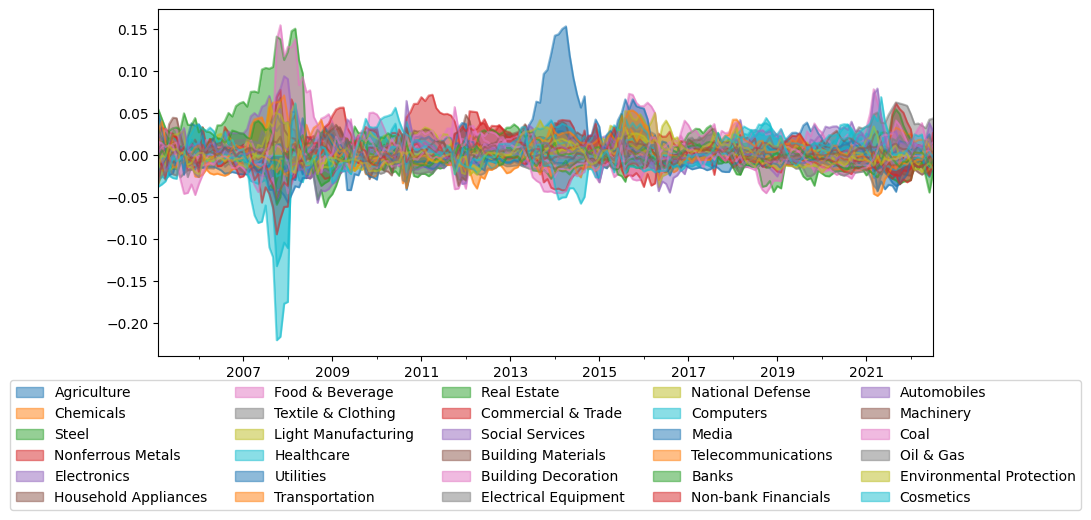

In [90]:
# plot with filling the area between the lines and zero
factor_exposures_rolling_pivot = factor_exposures_rolling[['alpha']].pivot_table(index=factor_exposures_rolling.index.get_level_values(1), 
                                           columns=factor_exposures_rolling.index.get_level_values(0)).droplevel(0, axis=1)
factor_exposures_rolling_pivot.columns = factor_exposures_rolling_pivot.columns.map(converter, na_action='ignore')
ax = factor_exposures_rolling_pivot.plot(kind='area', 
                                        stacked=False,
                                        figsize=(10, 4.5))
ax.set_xlabel("")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fancybox=True)

In [ ]:
# calculate the mean and stds for the rolling alphas annualized
factor_exposures_rolling_annualized_mean = factor_exposures_rolling[['alpha']].groupby(level=1).mean() * 12
factor_exposures_rolling_annualized_std = factor_exposures_rolling[['alpha']].groupby(level=1).std() * np.sqrt(12)

In [102]:
# calculate the mean and stds for the rolling alphas annualized
alpha_mean_std = pd.DataFrame(index=factor_exposures_rolling_pivot.columns, columns=['mean', 'std'])
for sector in factor_exposures_rolling_pivot.columns:
    mean, std = factor_exposures_rolling_pivot[sector].dropna().agg(['mean', 'std'])
    alpha_mean_std.loc[sector] = mean*12, std*np.sqrt(12)
alpha_mean_std = alpha_mean_std * 100

In [103]:
alpha_mean_std.rename(columns={'mean': 'Mean(%)', 'std': 'Std(%)'}, inplace=True)

In [114]:
alpha_mean_std = alpha_mean_std.convert_dtypes(float).round(2)

In [134]:
# check for how long does the alpha stay positive, in general
factor_exposures_rolling_pivot_positive = factor_exposures_rolling_pivot > 0
factor_exposures_rolling_pivot_positive = factor_exposures_rolling_pivot_positive.sum()
factor_exposures_rolling_pivot_positive = factor_exposures_rolling_pivot_positive / 210 * 100
factor_exposures_rolling_pivot_positive = factor_exposures_rolling_pivot_positive.convert_dtypes(float).round(2)

In [136]:
factor_exposures_rolling_pivot_negative = factor_exposures_rolling_pivot < 0
factor_exposures_rolling_pivot_negative = factor_exposures_rolling_pivot_negative.sum()
factor_exposures_rolling_pivot_negative = factor_exposures_rolling_pivot_negative / 210 * 100
factor_exposures_rolling_pivot_negative = factor_exposures_rolling_pivot_negative.convert_dtypes(float).round(2)

## NEXT we calculate noise using the TNR Ratio

In [202]:
# calculate trend to noise ratio
tnr_df = pd.DataFrame(index=sector_df_monthly.index, columns=sector_df_monthly.columns)
for ticker in sector_df_monthly.columns:
    tnr_df[ticker] = sector_df_monthly[ticker].rolling(12).apply(lambda x: x.sum() / x.diff().abs().sum())
tnr_df.dropna(inplace=True)
tnr_df.columns = tnr_df.columns.map(converter, na_action='ignore')

In [229]:
tnr_df = tnr_df.loc[factor_exposures_rolling_pivot.index.to_period('M')]
factor_exposures_rolling_pivot.index = factor_exposures_rolling_pivot.index.to_period('M')

In [230]:
# calculate correlation between the alphas and the trend to noise ratio
alpha_tnr_corr = pd.DataFrame(index=tnr_df.columns, columns=['corr'])
for sector in tnr_df.columns:
    alpha_tnr_corr.loc[sector] = tnr_df[sector].corr(factor_exposures_rolling_pivot[sector])

In [236]:
# calculate correlation between the alphas and the trend to noise ratio in different lags
alpha_tnr_corr_wlags = pd.DataFrame(index=tnr_df.columns, columns=range(1, 13))
for sector in tnr_df.columns:
    alpha_tnr_corr_wlags.loc[sector] = [tnr_df[sector].corr(factor_exposures_rolling_pivot[sector].shift(i)) for i in range(1, 13)]

In [258]:
# calculate regression between the alphas and the trend to noise ratio with lags
alpha_tnr_reg = pd.DataFrame(index=tnr_df.columns, columns=[('tnr_beta' + str(i), 'p_tnr' + str(i)) for i in range(1, 13)])
for i in range(1, 13):
    for sector in tnr_df.columns:
        X = sm.add_constant(tnr_df[sector].shift(i).fillna(0))
        model = sm.OLS(factor_exposures_rolling_pivot[sector], X)
        results = model.fit()
        alpha_tnr_reg.loc[sector][('tnr_beta' + str(i), 'p_tnr' + str(i))] = (results.params[1], results.pvalues[1])

In [270]:
# round each value to 3 decimal places, each value is a tuple
alpha_tnr_reg = alpha_tnr_reg.applymap(lambda x: tuple(map(lambda y: round(y, 3), x)))

In [272]:
# iterate through every value in the dataframe and add stars to the p-values, every value is in tuples so only apply to the second element
alpha_tnr_reg_wstar = alpha_tnr_reg.applymap(lambda x: (x[0], significance_stars(x[1])))

In [277]:
# calculate how many betas are significant out of every value in the matrix
alpha_tnr_reg_wstar_significant = alpha_tnr_reg_wstar.applymap(lambda x: x[1] == '***')
alpha_tnr_reg_wstar_significant.sum().sum() / alpha_tnr_reg_wstar_significant.size

0.5416666666666666

## More than 50% of the betas are significant. Very good!